# STA/STC Receptive Field Models for LNP Neurons / Correlated Noise

This notebook demonstrates spike-triggered average (STA) and spike triggered covaraiance (STC) models for neural responses. It uses the output of synthetic, Linear-Nonlinear Poisson (LNP) neurons as a data source.

Inspiration/code from:
1. _"Analysis of Neuronal Spike Trains, Deconstructed"_, by J. Aljadeff, B.J. Lansdell, A.L. Fairhall and D. Kleinfeld (2016) Neuron, 91 http://dx.doi.org/10.1016/j.neuron.2016.05.039 
2. _"Spike-triggered neural characterization"_, by Schwartz, O, Pillow, JW, Rust, NC, and Simoncelli, EP. (2006).  Journal of Vision, 6 [Code](http://pillowlab.princeton.edu/code_STC.html)

** TODO: add more inline annotation and consistent labeling **

_SLH 2017_

In [1]:
import numpy as np
from scipy import linalg,signal,interpolate

import matplotlib.pyplot as plt
import matplotlib as mpl
import pylab

%matplotlib inline

In [2]:
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

## Stimuli

Stimuli for this demo are 1) Gaussian white noise $\mathbf{s_g}$, which is a specific example of an "elliptical" distrubution where the STA will yield the best estimate of a linear receptive field, 2) correlated gaussian white noise $\mathbf{s_c}$, which will cause the naive STA to misrepresent the features that best drive the LNP neuron. 

$$
\mathbf{s_g} : \textrm{gaussian white noise stimulus vector} \sim \mathcal{N}(\mu,\,\sigma^{2})\,.
\\
\mu = 1, \sigma^{2} = 1
\\
\mathbf{s_c} : \textrm{correlated gaussian white noise} =  \mathbf{s_g} \ast e^{-t/\tau}
\\
\tau = see\ below
$$

In [3]:
stim_len = 5000000
np.random.seed(14)

# gaussian white noise stimulus
stim_g = np.random.normal(0,1,size=stim_len)

# length of filters + correlation scale, note they are matched so this problem is much easier
nfilt = 30

# exponential filter
te = np.arange(0,nfilt)
tau = np.round(nfilt*.333)
exp_filt = np.exp(-te/(tau))
exp_filt = exp_filt / linalg.norm(exp_filt)

# generate correlated gaussian white noise
stim_c = np.convolve(stim_g,exp_filt)[:stim_len]

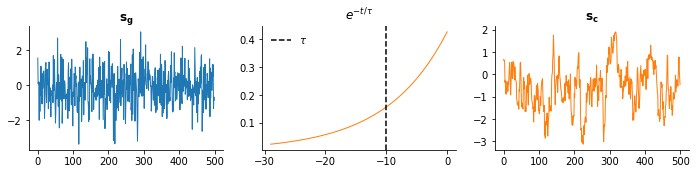

In [4]:
# Inspect signal processing
fig = plt.figure(figsize=(16,5));

ax = plt.subplot(2, 4, 1);
ax.plot(stim_g[:500],lw=1,color='C0');
ax.set_title('$\mathbf{s_g}$');

ax = plt.subplot(2, 4, 2);
ax.plot(-te,exp_filt,lw=1,color='C1');
ax.axvline(-tau,linestyle='--',color='black',label=r'$\tau$');
ax.legend(frameon=False);
ax.set_title(r'$e^{-t/\tau}$');

ax = plt.subplot(2, 4, 3);
ax.plot(stim_c[:500],lw=1,color='C1');
ax.set_title('$\mathbf{s_c}$');

## LNP Cascade

This LNP casecade has two (nonorthogonal) filters and static nonlinearity to define the rate of a poisson process. This is a pretty straighforward model, we want several thousand spikes to recover a good estimate of the feature vectors. The correlated noise will tend to drive more spikes because of our filter widths.

In [207]:
def calc_lnp_output(stim,filt1,filt2,w1=50,w2=50):
    stim_len = stim.shape[0]
    
    # Linear output for each filter
    cf1 = np.convolve(stim,filt1)[:stim_len]
    cf2 = np.convolve(stim,filt2)[:stim_len]
    
    # nonlinearity, with weighted sum
    rate = w1*np.maximum(cf1,0) + w2*np.maximum(cf2,0)
    #rate = w1/10*cf1**2 + w2/10*cf2**2
    
    # Get spiking output, simple method
    spikes = np.random.poisson(rate*tbin)
    
    return (spikes,rate)

In [6]:
# Time resolution for this simulation is miliseconds
tbin = 0.001

tf = np.arange(0,nfilt)

# Filter 1: Simple ingegrating alpha-like function filter
alpha1 = 0.4
filt1 = alpha1 * np.exp(-alpha1*tf) * (alpha1*tf)**4

# Filter 2: Biphasic filter 
alpha2 = 0.75
filt2 = alpha2 * np.exp(-alpha2*tf) * ((alpha2*tf)**5/np.math.factorial(5) - (alpha2*tf)**7/np.math.factorial(7))

# Normalize filters
filt1 = filt1 / linalg.norm(filt1)
filt2 = filt2 / linalg.norm(filt2)

# Weights for each filter
w1 = 10
w2 = 10

# Get spiking output for both stimuli
spikes_g,rate_g = calc_lnp_output(stim_g,filt1,filt2,w1=w1,w2=w2)
spikes_c,rate_c = calc_lnp_output(stim_c,filt1,filt2,w1=w1,w2=w2)

n_spikes_g = np.sum(spikes_g,axis=0)
n_spikes_c = np.sum(spikes_c,axis=0)
print("Gaussian noise: {} spikes\nCorrelated noise: {} spikes".format(n_spikes_g,n_spikes_c))

# weighted sum of filters for comparison with STA
filt_sum = w1*filt1+w2*filt2
filt_sum = filt_sum / linalg.norm(filt_sum)

Gaussian noise: 39966 spikes
Correlated noise: 96521 spikes


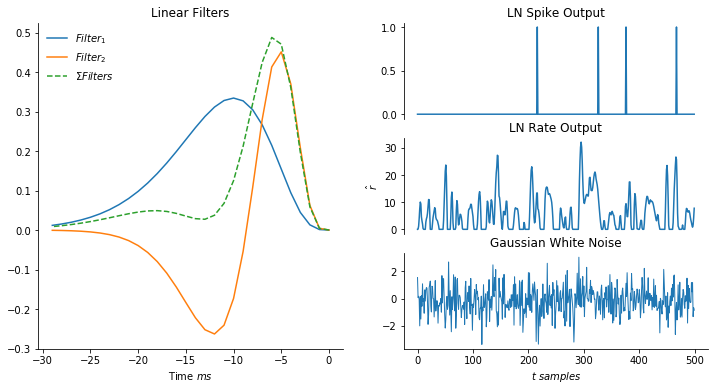

In [7]:
# Inspect LNP Cascade
fig = plt.figure(figsize=(12,6));

# Plot the linear filters and naive sum
ax1 = plt.subplot(1, 2, 1);
ax1.plot(-tf,filt1,label='$Filter_1$');
ax1.hold
ax1.plot(-tf,filt2,label='$Filter_2$');
ax1.plot(-tf,filt_sum,label='$\Sigma{} Filters$',linestyle='--');
ax1.legend(frameon=False);
ax1.set_title('Linear Filters');
ax1.set_xlabel('Time $ms$');

# Plot rate output
ax2 = plt.subplot(3, 2, 2);
ax2.plot(spikes_g[:500],color='C0');
ax2.xaxis.set_visible(False);
ax2.spines["bottom"].set_visible(False);
ax2.set_title("LN Spike Output");

ax2 = plt.subplot(3, 2, 4);
ax2.plot(rate_g[:500],color='C0');
ax2.xaxis.set_visible(False);
ax2.spines["bottom"].set_visible(False);
ax2.set_title("LN Rate Output");
ax2.set_ylabel(r"$\hat{r}$");

ax2 = plt.subplot(3, 2, 6);
ax2.plot(stim_g[:500],lw=1,color='C0');
ax2.set_title("Gaussian White Noise");
ax2.set_xlabel(r"$t\ samples$");

## STA +/- whitening

Simple calculation of the spike-triggered average, accounting for stimulus correlations if whitened.

It is very easy to calculate the STA and whitened STA using the design matrix from regression analysis (see J Pillow's GLM demo). In this case it is just several copies of the stimulus shifted different amounts in time (with zero padding) in each in a column. It is easier to look at the matrix below to see why this is useful...

In [8]:
def make_design_mat(stim,nfilt):
    pad = np.zeros(nfilt-1)
    pad_stim = np.concatenate((pad,stim))    
    design_mat = linalg.hankel(c=pad_stim[0:1-nfilt],r=stim[-nfilt:])

    return design_mat

In [9]:
# Make design matricies
d_mat_g = make_design_mat(stim_g,nfilt=nfilt)
d_mat_c = make_design_mat(stim_c,nfilt=nfilt)

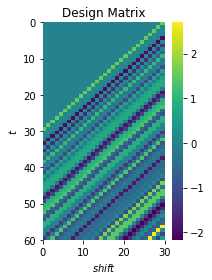

In [10]:
plt.figure(figsize=(6,4))
ax = plt.subplot(1, 2, 1);
pylab.pcolormesh(d_mat_g[0:nfilt*2,:]);
pylab.colorbar().outline.set_visible(False);
ax.invert_yaxis();
ax.set_title('Design Matrix');
ax.set_ylabel(r"$t$");
ax.set_xlabel(r"$shift$");
ax.spines["left"].set_visible(False);
ax.spines["bottom"].set_visible(False);

In [11]:
# Calculate STA in one line!
sta_g = np.dot(d_mat_g.T,spikes_g) / n_spikes_g
sta_g = sta_g / linalg.norm(sta_g)

sta_c = np.dot(d_mat_c.T,spikes_c) / n_spikes_c
sta_c = sta_c / linalg.norm(sta_c)

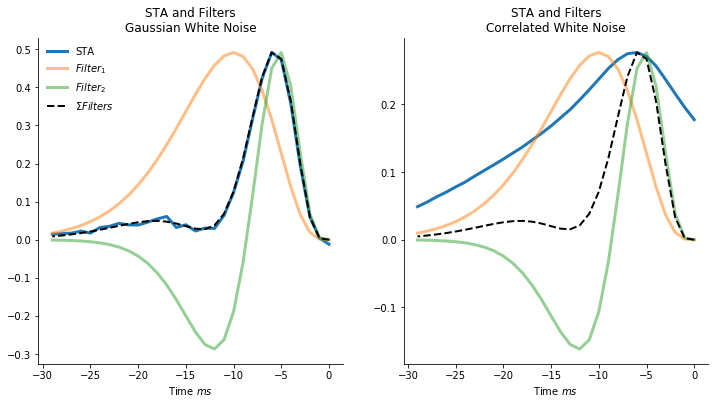

In [12]:
# Look at naive filters and STAs
fig = plt.figure(figsize=(12,6));

# Plot the linear filters and naive sum
ax1 = plt.subplot(1, 2, 1);
ax1.plot(-tf,sta_g[::-1],label='STA',lw=3,color='C0');
ax1.hold;
ax1.plot(-tf,filt1/np.max(filt1)*np.max(sta_g),label='$Filter_1$',lw=3,alpha=.5,color='C1');
ax1.plot(-tf,filt2/np.max(filt2)*np.max(sta_g),label='$Filter_2$',lw=3,alpha=.5,color='C2');
ax1.plot(-tf,filt_sum/np.max(filt_sum)*np.max(sta_g),label='$\Sigma{} Filters$',linestyle='--',lw=2,alpha=1,color='k');
ax1.legend(frameon=False);
ax1.set_title('STA and Filters\nGaussian White Noise');
ax1.set_xlabel('Time $ms$');

# Plot the linear filters and naive sum
ax1 = plt.subplot(1, 2, 2);
ax1.plot(-tf,sta_c[::-1],label='STA',lw=3,color='C0');
ax1.hold;
ax1.plot(-tf,filt1/np.max(filt1)*np.max(sta_c),label='$Filter_1$',lw=3,alpha=.5,color='C1');
ax1.plot(-tf,filt2/np.max(filt2)*np.max(sta_c),label='$Filter_2$',lw=3,alpha=.5,color='C2');
ax1.plot(-tf,filt_sum/np.max(filt_sum)*np.max(sta_c),label='$\Sigma{} Filters$',linestyle='--',lw=2,alpha=1,color='k');
ax1.set_title('STA and Filters\nCorrelated White Noise');
ax1.set_xlabel('Time $ms$');

In [13]:
def calc_cov_mat(design_mat,spikes=None):
    """
    Calculate the stimulus covariance matrix from design matrix
    optionally make it spike triggered. 
    
    This is part of the "zero-centered" method described by Aljadeff et al 2013
    where the covariance difference matrix is later diagonalized.
    
    spikes must have the same number of entries as design matrix has rows
    """
    if spikes is None:
        mu = np.mean(design_mat,axis=0)
        D = design_mat - mu
    else:
        mu = np.dot(design_mat.T,spikes)
        D = design_mat[spikes > 0] - mu

    C = np.cov(D.T,bias=False)
    
    return(C,mu)

In [14]:
# Caclulate the stimulus covariance matricies
Cg = calc_cov_mat(d_mat_g)[0]
Cc = calc_cov_mat(d_mat_c)[0]

# Normalize the STA by covariance matrix

# Ridge parameter will smooth
#ridge = .5
#C_inv = linalg.inv(C + ridge*np.eye(C.shape[0]))

# Regularize the inverse matrix... no sweep here just eyeballing
rcond=.025
Cc_inv,rank = linalg.pinv(Cc,rcond=rcond,return_rank=True)

# w_sta_g = np.dot(Cc_inv.T,sta_g)
# w_sta_g = w_sta_g / linalg.norm(w_sta_g)

w_sta_c = np.dot(Cc_inv.T,sta_c)
w_sta_c = w_sta_c / linalg.norm(w_sta_c)

print("Rank of pseudoinverse matrix : {}".format(rank))

Rank of pseudoinverse matrix : 8


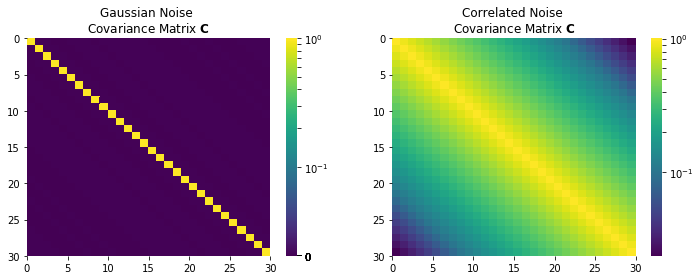

In [15]:
# Look at correlations in time
fig = plt.figure(figsize=(12,4));
for i,(X,desc) in enumerate(zip([Cg,Cc],['Gaussian','Correlated'])):
    ax = plt.subplot(1, 2, 1+i);
    pylab.pcolormesh(X,norm=mpl.colors.SymLogNorm(vmin=X.min(),vmax=X.max(),linthresh=0.1));
    pylab.colorbar().outline.set_visible(False);
    ax.spines["left"].set_visible(False);
    ax.spines["bottom"].set_visible(False);
    ax.invert_yaxis();
    ax.set_title(desc + ' Noise \nCovariance Matrix $\mathbf{C}$');

In [16]:
Uc,sc = linalg.svd(Cc)[0:2]

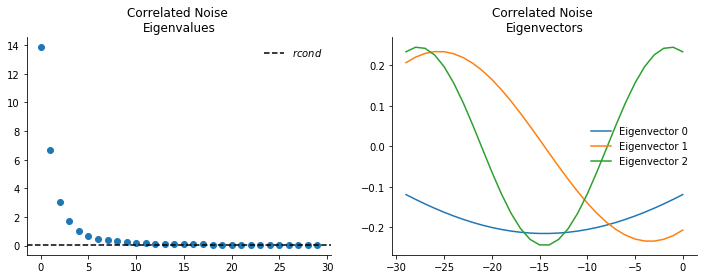

In [17]:
fig = plt.figure(figsize=(12,4));

# Plot eigenvalues
ax1 = plt.subplot(1, 2, 1);
ax1.plot(sc,'o');
ax1.hold;
ax1.axhline(rcond,linestyle='--',color='black',label=r'$rcond$');
ax1.set_title('Correlated Noise \nEigenvalues');
ax1.legend(frameon=False);

# Plot eigenvectors
ax2 = plt.subplot(1, 2, 2);
for i in range(3):
    ax2.plot(-tf,Uc[:,i],'-',label="Eigenvector " + str(i));
    ax2.hold;
ax2.set_title('Correlated Noise \nEigenvectors');
ax2.legend(frameon=False);

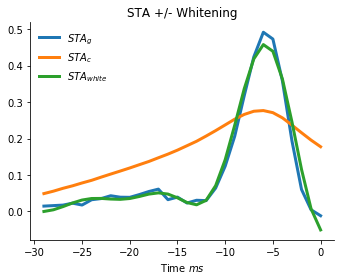

In [18]:
fig = plt.figure(figsize=(12,4));

# Plot the linear filters and naive sum
ax1 = plt.subplot(1, 2, 1);
ax1.plot(-tf,sta_g[::-1],label='$STA_{g}$',lw=3,color='C0');
ax1.hold;
ax1.plot(-tf,sta_c[::-1],label='$STA_{c}$',lw=3,color='C1');
ax1.plot(-tf,w_sta_c[::-1],label='$STA_{white}$',lw=3,color='C2');
ax1.legend(frameon=False);
ax1.set_title('STA +/- Whitening');
ax1.set_xlabel('Time $ms$');

## STC +/- whitening

Calculate the spike-triggered covariance of the stimulus. Test regularization on the matrix inversion too e.g. `np.pinv()`.

In [19]:
# Covariance difference matrix for gaussian noise
Cg_st,sta_g2 = calc_cov_mat(d_mat_g,spikes_g)
Cg_diff = Cg_st-Cg

# Covariance difference matrix for correlated noise
Cc_st,sta_c2 = calc_cov_mat(d_mat_c,spikes_c)
Cc_diff = Cc_st-Cc

Note below that in the "zero-centered" STC method Diag[$\mathbf{C}$] won't pop out

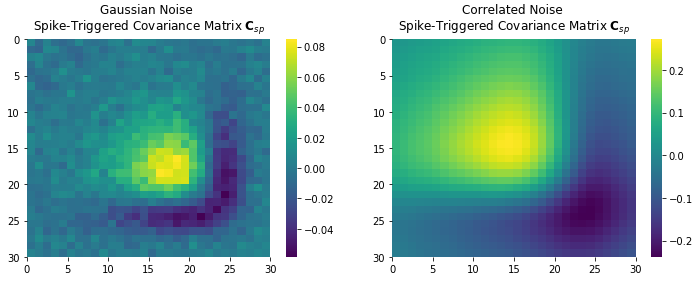

In [20]:
fig = plt.figure(figsize=(12,4));
for i,(X,desc) in enumerate(zip([Cg_diff,Cc_diff],['Gaussian','Correlated'])):
    ax = plt.subplot(1, 2, 1+i);
    pylab.pcolormesh(X);
    pylab.colorbar().outline.set_visible(False);
    ax.spines["left"].set_visible(False);
    ax.spines["bottom"].set_visible(False);
    ax.invert_yaxis();
    ax.set_title(desc + ' Noise \nSpike-Triggered Covariance Matrix $\mathbf{C}_{sp}$');

In [21]:
# Diagonalize both of the difference matricies
Ug_st,sg_st = linalg.svd(Cg_diff)[:-1]
Uc_st,sc_st = linalg.svd(Cc_diff)[:-1]

In [22]:
# Whiten correlated stimulus matrix
w_Uc_st = np.dot(Cc_inv.T,Uc_st)
w_Uc_st = w_Uc_st / linalg.norm(w_Uc_st,axis=0)

In [23]:
## TODO!
# Use random matrix for significantce on white distrubuted stimulus...

In [24]:
# Bootstrap for eigenvalue significance on non-white stimulus
nreps = 1000
bs_meth = 1

s_rand = []
nsamps = spikes_c.shape[0]
for i in range(nreps):
    if bs_meth == 1:
    # Preserve spike train structure
        shift = np.random.randint(0,high=nsamps)
        shift_inds = np.mod(shift + np.arange(0,nsamps),nsamps)
        rand_spikes = spikes_c.copy()
        rand_spikes = rand_spikes[shift_inds]
    elif bs_meth == 2:
        # Completely new spike locations, with possible overlaps
        rand_spikes = np.zeros_like(spikes_c)
        rand_inds = np.random.randint(0,nsamps,size=n_spikes_c)
        uq_inds,counts = np.unique(rand_inds,return_counts=True)
        rand_spikes[uq_inds] = counts

    Cr = calc_cov_mat(d_mat_c,rand_spikes)[0]
    s_rand.append(linalg.svd(Cr - Cc,compute_uv=False))
s_rand = np.array(s_rand)

In [25]:
# Determine significant eigenvectors to use
sig_bounds = np.percentile(s_rand,q=[0,100])
s = sc_st
sig_bool = (s < sig_bounds[0]) | (s > sig_bounds[1])
sig_inds = np.where(sig_bool)[0]
insig_inds = np.where(~sig_bool)[0]
print("Significant Eigenvector inds: {} ".format(sig_inds))

Significant Eigenvector inds: [0 1] 


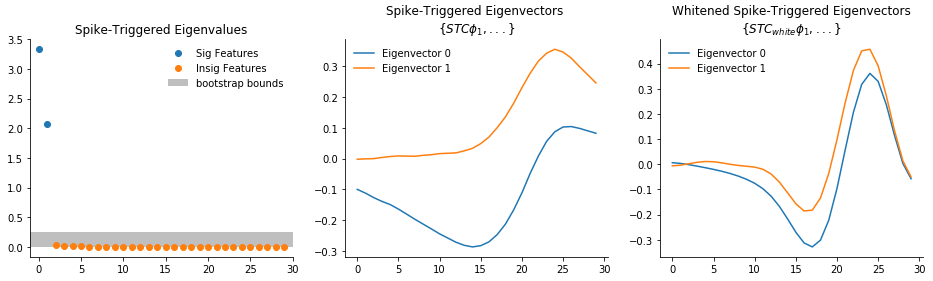

In [26]:
fig = plt.figure(figsize=(16,4));

ax1 = plt.subplot(1, 3, 1);
ax1.fill_between(np.arange(-2,33),sig_bounds[0],sig_bounds[1],alpha=0.5,facecolor='gray',label='bootstrap bounds');
ax1.hold;
ax1.plot(sig_inds,sc_st[sig_inds],'o',color='C0',label='Sig Features');
ax1.plot(insig_inds,sc_st[insig_inds],'o',color='C1',label='Insig Features');
ax1.set_xlim(-1,30)
#ax1.axhline(sig_bounds[0],linestyle='--',alpha=.5,color='black',label=r'$rcond$');
#ax1.axhline(sig_bounds[1],linestyle='--',alpha=.5,color='black',label=r'$rcond$');
ax1.set_title('Spike-Triggered Eigenvalues');
ax1.legend(frameon=False);

ax2 = plt.subplot(1, 3, 2);
for i in sig_inds:
    ax2.plot(tf,Uc_st[:,i]/linalg.norm(Uc_st[:,i]),'-',label="Eigenvector " + str(i));
    ax2.hold;
ax2.set_title('Spike-Triggered Eigenvectors \n$\{STC\phi_1,...\}$');
ax2.legend(frameon=False);

ax2 = plt.subplot(1, 3, 3);
for i in sig_inds:
    ax2.plot(tf,w_Uc_st[:,i],'-',label="Eigenvector " + str(i));
    ax2.hold;
ax2.set_title('Whitened Spike-Triggered Eigenvectors\n$\{STC_{white}\phi_1,...\}$');
ax2.legend(frameon=False);

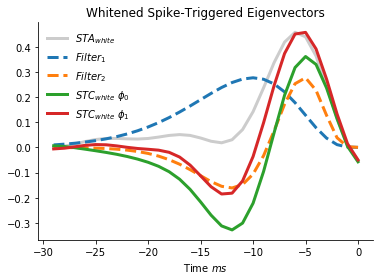

In [27]:
# Plot whitened STC features
fig = plt.figure(figsize=(6,4));

ax2 = plt.subplot(1, 1, 1);
ax2.plot(-tf,w_sta_c[::-1],label='$STA_{white}$',linestyle='-',lw=3,color='k',alpha=0.2);
ax2.hold;
ax2.plot(-tf,filt1/np.max(filt1)*np.max(sta_c),linestyle='--',label='$Filter_1$',lw=3,alpha=1);
ax2.plot(-tf,filt2/np.max(filt2)*np.max(sta_c),linestyle='--',label='$Filter_2$',lw=3,alpha=1);

for i in sig_inds[::1]:
    psi = np.dot(Cc_inv.T,Uc_st[:,i])
    psi = psi / linalg.norm(psi)
    ax2.plot(-tf,psi[::-1],linestyle='-',lw=3,label="$STC_{white}\ \phi_{"+str(i)+"}$");
    ax2.hold;
ax2.set_title('Whitened Spike-Triggered Eigenvectors');
ax2.set_xlabel('Time $ms$');
ax2.legend(frameon=False);

## Spiking Nonlinearity for STA/STC

Calculate the nonlinearity for the models and check relative performance.

As outlined in the papers referenced above, a combined STA, STC model can also be formulated and might make sense to use if the STA is mostly overlapping with significant STC features. STC features can also be orthogonalized to the STA, kind of depends on how it all looks :)

Bin the spiking rate output as a function of the STA-projected stimulus value, and interpolate between bins and rectify to estimate nonlinearity

In [176]:
# Direct estimation from projection and mean rate in bins
def nl_from_binned_proj(proj,spikes,nbins):
    
    # Range of values for projected stimulus
    proj_rng = np.ptp(np.fabs(proj))+1e-5
    edges = np.linspace(-proj_rng,+proj_rng,num=nbins+1,endpoint=True)
    cents = edges[:-1] + (edges[1] - edges[0])

    # bin ind for each projected stimulus value
    bin_proj = np.digitize(proj,edges,right=True)
    # inds 0 and len(bins) are out of range for my bins so ignored
    # Note I don't know why this happens...
    bin_proj = bin_proj[(bin_proj > 0) & (bin_proj < len(edges))]

    counts = np.histogram(proj,bins=edges)[0]

    # average number of spikes for each bin in NL func
    nl = []
    for i in range(nbins):
        bin_inds = np.where(bin_proj==i+1)[0]
        bin_spikes = np.mean(spikes[bin_inds])
        nl.append(bin_spikes)
    nl = np.array(nl)
    
    return (nl,counts,edges,cents)

def nl_from_bayes(proj,spikes,nbins):
    proj_rng = np.ptp(np.fabs(proj))+1e-5
    edges = np.linspace(-proj_rng,+proj_rng,num=nbins+1,endpoint=True)
    bin_size = edges[1] - edges[0]
    cents = edges[:-1] + bin_size

    # bin ind for each projected stimulus value
    bin_proj = np.digitize(proj,edges,right=True)

    # Prior probability of a spike (just the rate)
    Ps = n_spikes / stim.shape[0]

    # Prior probability of stimulus features
    # Equiv to: np.histogram(proj,bins=edges)[0] / (stim.shape[0] * bin_size**2)
    Pf = np.histogram(proj,bins=edges,density=True)[0]

    # Probability of features conditioned on spikes
    bool_spikes = spikes > 0
    # Equiv to: np.histogram(proj[bool_spikes],bins=edges)[0] / (np.sum(bool_spikes) * bin_size**2)
    Pfs = np.histogram(proj[bool_spikes],bins=edges,density=True)[0]

    # By bayes
    Psf = Pfs*Ps/Pf
    nl = Psf
    
    # uhhh
    counts = []
    
    return (nl,counts,edges,cents)

# Get a smooth, well-behaved function for calculating model output
def interpolate_nl(nl):
    # Interpolate the raw nonlinearity (step 1)
    spl = interpolate.UnivariateSpline(np.arange(nl.shape[0]),nl)
    w = spl(np.arange(nl.shape[0]))

    return w,spl

def rectify_nl(nl,eps):
    # rectify the interpolated nonlinearity (step 2)
    # Get rid of zero values and add small offset for convergence
    g = np.piecewise(w,[w<0,w>=0],[eps,lambda x: x+eps])
    
    return g

def interp_rec_nl(nl,eps=1e-8):
    w,spl = interpolate_nl(nl)
    g = rectify_nl(w,eps)
    
    return g,spl

In [172]:
# Number of bins for nonlinearity
nbins = 20

# Easily switch between the two STAs here
sta_pick = 2

if sta_pick == 1:
# STA to gaussian white noise stimulus
    proj = np.dot(d_mat_g,sta_g)
    spikes = spikes_g
    n_spikes = n_spikes_g
    stim = stim_g
    descr = 'Gaussian White Noise'
elif sta_pick == 2:
    # whitened STA to correlated noise
    proj = np.dot(d_mat_c,w_sta_c)
    spikes = spikes_c
    n_spikes = n_spikes_c
    stim = stim_c
    descr = 'Correlated Gaussian Noise'

Direct estimate of NL, bin-wise rate lookup

In [173]:
# Determine spiking NL 'directly'
(nl,counts,bin_edges,bin_cents) = nl_from_binned_proj(proj,spikes,nbins)

# Interpolate+rectify the nonlinearity
rect_nl,rect_nl_spl = interp_rect_nl(nl)

# Normalize to get correct number of spikes from NL... something here is wrong!
norm_nl = rect_nl * (n_spikes / np.sum(rect_nl))

Use Bayes rule to calculate the probability of a spike given reduced dimensional (STA-projected) stimulus value. This ignores cases where there is more than one spike per sample interval.

In [174]:
# Bayes rule to get the nonlinearity
(nl_b,counts_b,bin_edges_b,bin_cents_b) = nl_from_bayes(proj,spikes,nbins)

# Interpolate+rectify the nonlinearity
rect_nl_b,rect_nl_b_spl = interp_rect_nl(nl_b)

# Normalize to get correct number of spikes from NL... something here is wrong!
norm_nl_b = rect_nl_b * (n_spikes / np.sum(rect_nl_b))

Plot both NL estimates

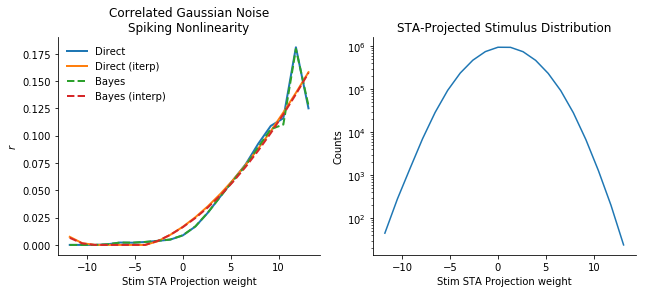

In [129]:
# Plot the nonlinearity in all it's glory
fig = plt.figure(figsize=(16,4));

ax1 = plt.subplot(1, 3, 1);
ax1.plot(bin_cents,nl,label='Direct',lw=2);
ax1.hold;
ax1.plot(bin_cents,rect_nl,label='Direct (iterp)',lw=2);
ax1.plot(bin_cents_b,nl_b,label='Bayes',lw=2,linestyle='--');
ax1.plot(bin_cents_b,rect_nl_b,label='Bayes (interp)',lw=2,linestyle='--');
ax1.set_title(descr + '\nSpiking Nonlinearity');
ax1.set_xlabel('Stim STA Projection weight');
ax1.set_ylabel('$r$')
ax1.legend(frameon=False)

ax2 = plt.subplot(1,3,2);
ax2.plot(bin_cents,counts);
plt.yscale('log');
ax2.set_title('STA-Projected Stimulus Distribution');
ax2.set_xlabel('Stim STA Projection weight');
ax2.set_ylabel('Counts');

Use these methods now on the STC model with the correlated stimuli. Note that now the model is in 2D so different functions (for binning, interpolation etc.,) are required.

In [130]:
# projection with just the significant (whitened) eigenvectors
proj = np.zeros((stim.shape[0],sig_inds.shape[0]));
for i,si in enumerate(sig_inds):
    #proj[:,i] = np.dot(d_mat_c,Uc_st[:,si])
    proj[:,i] = np.dot(d_mat_c,w_Uc_st[:,si])

spikes = spikes_c
n_spikes = n_spikes_c
descr = 'Correlated Gaussian Noise'

Calculate nonliearity using Bayes Rule

In [223]:
# Will assume the grids are equal for simplicity
proj_rng = np.ptp(np.fabs(proj))+1e-5
edges = np.linspace(-proj_rng,+proj_rng,num=nbins+1,endpoint=True)
bin_size = edges[1] - edges[0]
cents = edges[:-1] + bin_size

In [157]:
# Prior probability of stimulus features
Pf = np.histogramdd(proj,bins=np.array([edges,edges]),normed=True)[0]

# Probability of features conditioned on spikes
bool_spikes = spikes > 0
Pfs = np.histogramdd(proj[bool_spikes,:],bins=np.array([edges,edges]),normed=True)[0]

# Prior probability of a spike (just the rate)
Ps = n_spikes / stim.shape[0]

# By bayes, replace nan vals with zero
Psf = Pfs*Ps/Pf;
Psf[np.isnan(Psf)] = 0
nl2 = Psf

# Interpolate the nonlinearity
interp_edges = np.linspace(cents[0],cents[-1],nbins*10+1,endpoint=True)
interp_cents = interp_edges[:-1] + (interp_edges[1]-interp_edges[0])
xi = np.array(np.meshgrid(interp_cents,interp_cents)).T
w = interpolate.interpn(points=(cents,cents),values=nl2,xi=xi)

# Get rid of zero values and add small offset for convergence
eps = 1e-8
rect_nl2_interp = np.piecewise(w,[w<0,w>=0],[eps,lambda x: x+eps])

/Users/stephenholtz/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


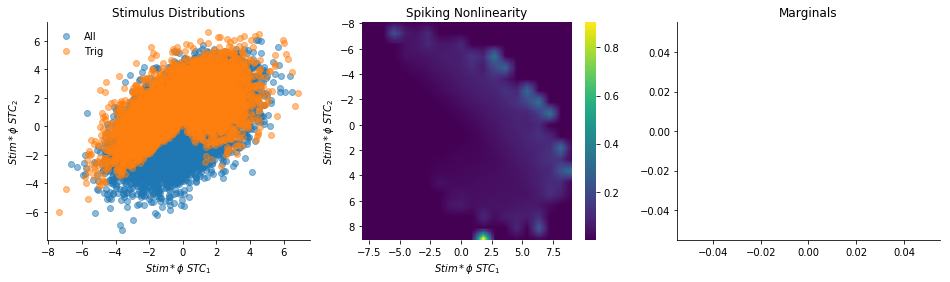

In [158]:
fig = plt.figure(figsize=(16,4));

# Inspect the projected stimulus etc
ax = plt.subplot(1, 3, 1);
rnd_proj = proj[np.random.randint(0,high=stim.shape[0],size=10000),:]
ax.plot(rnd_proj[:,0],rnd_proj[:,1],'o',label='All',alpha=.5);
ax.hold;
rnd_bool = np.random.randint(0,high=np.sum(bool_spikes),size=5000);
ax.plot(proj[bool_spikes,0][rnd_bool],proj[bool_spikes,1][rnd_bool],'o',label='Trig',alpha=.5);
ax.set_title('Stimulus Distributions');
ax.set_xlabel('$Stim * \phi \ STC_1$');
ax.set_ylabel('$Stim * \phi \ STC_2$');
ax.legend(frameon=False);

ax = plt.subplot(1, 3, 2);
pylab.pcolormesh(interp_cents,interp_cents,rect_nl_interp)
pylab.colorbar().outline.set_visible(False);
ax.spines["left"].set_visible(False);
ax.spines["bottom"].set_visible(False);
ax.invert_yaxis();
ax.set_title('Spiking Nonlinearity');
ax.set_xlabel('$Stim * \phi \ STC_1$');
ax.set_ylabel('$Stim * \phi \ STC_2$');

# Marginals for each
ax = plt.subplot(1, 3, 3);
ax.plot();
ax.set_title('Marginals');

The Nonlinearity really pops out on these ^

In [ ]:
# Look at predicted and actual spikes from the model



Directly calculate the nonliearity 

TODO

In [149]:
# for direct NL eval on > 1D
bin_proj = []
for i,si in enumerate(sig_inds):
    bin_proj.append(np.digitize(proj[:,i],edges,right=True))
bin_proj = np.array(bin_proj).T

# TODO!

## Model Performance

Compare the STA/STC models using freshly generated spiking output with Root Mean Squared Error (RMSE), and spectral coherence... which is a ton of matlab code I need to port

** TODO: add in log-likelihood **

In [208]:
# Generate 'test' spike trains, as if had held-out data
stim_len_test = np.int(stim_len / 4)
np.random.seed(101)

stim_g_test = np.random.normal(0,1,size=stim_len_test)
stim_c_test = np.convolve(stim_g_test,exp_filt)[:stim_len_test]

spikes_g_test,rate_g_test = calc_lnp_output(stim_g_test,filt1,filt2,w1=w1,w2=w2)
spikes_c_test,rate_c_test = calc_lnp_output(stim_c_test,filt1,filt2,w1=w1,w2=w2)

n_spikes_g_test = np.sum(spikes_g_test,axis=0)
n_spikes_c_test = np.sum(spikes_c_test,axis=0)
print("Gaussian noise: {} spikes\nCorrelated noise: {} spikes".format(n_spikes_g,n_spikes_c))

# Make design matrix
d_mat_c_test = make_design_mat(stim_c_test,nfilt=nfilt)

Gaussian noise: 39966 spikes
Correlated noise: 96521 spikes


In [209]:
proj_1d_t = np.dot(d_mat_c_test,w_sta_c)
w = rect_nl_b_spl(proj_1d_t)
rate_1d_t = rectify_nl(w,eps=1e-8)

rmse_c = np.mean((rate_c_test-rate_1d_t)**2)
rmse_c

In [216]:
proj_2d_t = np.zeros((stim_c_test.shape[0],sig_inds.shape[0]));
for i,si in enumerate(sig_inds):
    proj_2d_t[:,i] = np.dot(d_mat_c_test,w_Uc_st[:,si])

In [224]:
print(np.min(proj_2d_t),np.max(proj_2d_t))
print(cents)

-8.47636647275 8.02761386022
[ -1.18091207e+01  -1.04969961e+01  -9.18487163e+00  -7.87274711e+00
  -6.56062259e+00  -5.24849807e+00  -3.93637356e+00  -2.62424904e+00
  -1.31212452e+00  -1.77635684e-15   1.31212452e+00   2.62424904e+00
   3.93637356e+00   5.24849807e+00   6.56062259e+00   7.87274711e+00
   9.18487163e+00   1.04969961e+01   1.18091207e+01   1.31212452e+01]


In [ ]:
w = interpolate.interpn(points=(cents,cents),values=nl2,xi=proj_2d_t)

In [ ]:
rate_2d_t = rectify_nl(w,eps=1e-8)

rmse_c = np.mean((rate_c_test-rate_1_t)**2)
rmse_c